__Prediction:__

Planning to use regression models to predict wait time based on location, duration, speed and other parameters
1. Linear Regression (base model)
2. Regression using XgBoost

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split

import sklearn.metrics

from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations

import random
random.seed(321)

ModuleNotFoundError: No module named 'haversine'

__Observation:__
<font color = blue> Features from data prep-d earlier will be used here; final feature list will be based on running collinearity test and how model performs using these features </font>

In [6]:
df_trips = pd.read_csv('C:/Users/mohamed_musthafa/Desktop/Python Code/Trip Wait Time Prediction Assignment/taxi-routes-of-mexico-city-quito-and-more/Quito_clean.csv')

In [70]:
display(df_trips.shape)
display(df_trips.columns)

(29854, 15)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'dist_meters', 'wait_sec',
       'pDayofWeek', 'pYear', 'pMonth', 'pHour', 'avg_speed', 'pdate',
       'holiday', 'weekend'],
      dtype='object')

In [71]:
df_trips.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,pDayofWeek,pYear,pMonth,pHour,avg_speed,pdate,holiday,weekend
0,-78.503922,-0.232824,-78.549447,-0.361363,2025.0,24228.0,346.0,5.0,2016.0,9.0,9.0,43.0,2016-09-17,0,1
1,-78.440306,0.006789,-78.490786,-0.104836,1390.0,16680.0,456.0,6.0,2016.0,9.0,4.0,43.0,2016-09-18,0,1
2,-78.558076,-0.278241,-78.430220,-0.201934,1933.0,25146.0,302.0,6.0,2016.0,9.0,5.0,47.0,2016-09-18,0,1
3,-78.521818,-0.208480,-78.504558,-0.222462,948.0,4625.0,314.0,6.0,2016.0,9.0,7.0,18.0,2016-09-18,0,1
4,-78.509202,-0.194839,-78.518764,-0.228794,1510.0,5820.0,630.0,5.0,2016.0,8.0,4.0,14.0,2016-08-27,0,1


In [72]:
def haversine_(lat1, lng1, lat2, lng2):
    """haversine distance: 
    great-circle distance between two points on a sphere given their longitudes and latitudes."""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """manhatten distance: 
    sum of  horizontal and vertical distances between points on a grid"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """bearing:
    horizontal angle between direction of an object and another object"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [73]:
# distance related features 
# round to nearest meter
df_trips.loc[:,'hvsine_pick_drop'] = haversine_(df_trips['pickup_latitude'].values, 
                                                df_trips['pickup_longitude'].values, 
                                                df_trips['dropoff_latitude'].values, 
                                                df_trips['dropoff_longitude'].values)
df_trips.loc[:,'hvsine_pick_drop'] = np.round(df_trips.loc[:,'hvsine_pick_drop'], 3)
df_trips.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(df_trips['pickup_latitude'].values, 
                                                           df_trips['pickup_longitude'].values, 
                                                           df_trips['dropoff_latitude'].values, 
                                                           df_trips['dropoff_longitude'].values)
df_trips.loc[:,'manhtn_pick_drop'] = np.round(df_trips.loc[:,'manhtn_pick_drop'], 3)
# direction of travel
df_trips.loc[:,'bearing'] = bearing_array(df_trips['pickup_latitude'].values, 
                                          df_trips['pickup_longitude'].values, 
                                          df_trips['dropoff_latitude'].values, 
                                          df_trips['dropoff_longitude'].values)

In [74]:
df_trips.head(10)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,pDayofWeek,pYear,pMonth,pHour,avg_speed,pdate,holiday,weekend,hvsine_pick_drop,manhtn_pick_drop,bearing
0,-78.503922,-0.232824,-78.549447,-0.361363,2025.0,24228.0,346.0,5.0,2016.0,9.0,9.0,43.0,2016-09-17,0,1,15.163,19.355,-160.497490
1,-78.440306,0.006789,-78.490786,-0.104836,1390.0,16680.0,456.0,6.0,2016.0,9.0,4.0,43.0,2016-09-18,0,1,13.622,18.025,-155.666043
2,-78.558076,-0.278241,-78.430220,-0.201934,1933.0,25146.0,302.0,6.0,2016.0,9.0,5.0,47.0,2016-09-18,0,1,16.556,22.702,59.170663
3,-78.521818,-0.208480,-78.504558,-0.222462,948.0,4625.0,314.0,6.0,2016.0,9.0,7.0,18.0,2016-09-18,0,1,2.470,3.474,129.009607
4,-78.509202,-0.194839,-78.518764,-0.228794,1510.0,5820.0,630.0,5.0,2016.0,8.0,4.0,14.0,2016-08-27,0,1,3.923,4.839,-164.273273
5,-78.481542,-0.154317,-78.518420,-0.191547,1341.0,7593.0,510.0,6.0,2016.0,9.0,10.0,20.0,2016-09-18,0,1,5.827,8.241,-135.272833
6,-78.529780,-0.249149,-78.361078,-0.124627,2821.0,46418.0,302.0,6.0,2016.0,9.0,11.0,59.0,2016-09-18,0,1,23.315,32.605,53.568550
7,-78.361079,-0.124644,-78.392735,-0.089407,1100.0,8150.0,390.0,6.0,2016.0,9.0,11.0,27.0,2016-09-18,0,1,5.267,7.438,-41.934765
8,-78.497122,-0.200376,-78.499757,-0.207293,109.0,827.0,29.0,6.0,2016.0,9.0,12.0,27.0,2016-09-18,0,1,0.823,1.062,-159.143162
9,-78.499770,-0.207324,-78.506766,-0.226037,495.0,2549.0,129.0,6.0,2016.0,9.0,12.0,19.0,2016-09-18,0,1,2.221,2.859,-159.502326


In [75]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29854 entries, 0 to 29853
Data columns (total 18 columns):
pickup_longitude     29854 non-null float64
pickup_latitude      29854 non-null float64
dropoff_longitude    29854 non-null float64
dropoff_latitude     29854 non-null float64
trip_duration        29854 non-null float64
dist_meters          29854 non-null float64
wait_sec             29854 non-null float64
pDayofWeek           29854 non-null float64
pYear                29854 non-null float64
pMonth               29854 non-null float64
pHour                29854 non-null float64
avg_speed            29854 non-null float64
pdate                29854 non-null object
holiday              29854 non-null int64
weekend              29854 non-null int64
hvsine_pick_drop     29854 non-null float64
manhtn_pick_drop     29854 non-null float64
bearing              29854 non-null float64
dtypes: float64(15), int64(2), object(1)
memory usage: 4.1+ MB


In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

cols = ['trip_duration', 'dist_meters',
       'pDayofWeek', 'pYear', 'pMonth', 'pHour', 'avg_speed', 'holiday', 'weekend', 'hvsine_pick_drop', 'manhtn_pick_drop',
       'bearing'        ]
vif_list = calculate_vif_(df_trips[cols])

dropping 'manhtn_pick_drop' at index: 10
dropping 'pYear' at index: 3
dropping 'pDayofWeek' at index: 2
Remaining variables:
Index(['trip_duration', 'dist_meters', 'pMonth', 'pHour', 'avg_speed',
       'holiday', 'weekend', 'hvsine_pick_drop', 'bearing'],
      dtype='object')


__Observation:__
<font color=blue> pYear and pDayofWeek turned out to be highly collinear (vif>5); dropping these features from final list </font>

In [77]:
# transforming continuous features
df_trips['trip_duration_log'] = np.round(np.log1p(df_trips['trip_duration']), 5)
df_trips['dist_meters_log'] = np.round(np.log1p(df_trips['dist_meters']), 5)
#df_trips['avg_speed_log'] = np.round(np.log1p(df_trips['avg_speed']), 5) #no need to log transform

In [78]:
cols = ['pickup_longitude', 'pickup_latitude', 
        'dropoff_longitude',       'dropoff_latitude', 
        'trip_duration_log', 'dist_meters_log', 
        'pDayofWeek',       'pYear', #removed these varaibles due to high correlation
        'pMonth', 
        'pHour', 'holiday', 'weekend', 'avg_speed', 'hvsine_pick_drop', 'manhtn_pick_drop',
       'bearing' ]

# cols = ['trip_duration_log', 'dist_meters_log', 'pMonth', 'pHour', 'holiday', 'weekend',
#        'avg_speed']

X = df_trips[cols].copy()
y = np.log1p(df_trips['wait_sec'].copy())

random.seed(42)
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

print('Dataset size\nTraining:', X_train.shape[0], '\nTesting:', X_test.shape[0])

Dataset size
Training: 23883 
Testing: 5971


C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


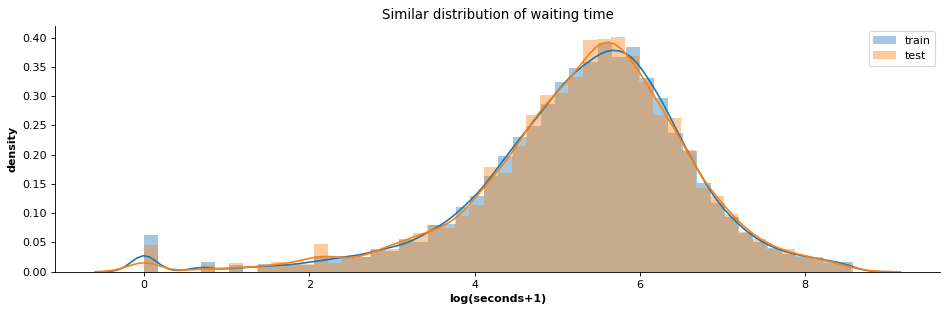

In [79]:
fig = figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

sns.distplot(y_train.values, label='train',)
             #kde_kws=dict(cumulative=True))
sns.distplot(y_test.values, label='test',)
             #kde_kws=dict(cumulative=True))
plt.title('Similar distribution of waiting time')
plt.legend(loc=0)
plt.ylabel('density', weight = 'bold')
plt.xlabel('log(seconds+1)', weight = 'bold')
sns.despine()
plt.tight_layout();

__Observation:__
<font color=blue> Train and test data split distribution looks good; proceeding forward with these datasets. </font>

__Linear Regression__

In [80]:
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

reg = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)


#estimation scores - Array of scores of the estimator for each run of the cross validation
scores = cross_val_score(reg, X_train, y_train, cv=cv, error_score=np.nan, scoring='r2')
print('R2: ', scores.mean()) #Rsquared

#estimation scores - Array of scores of the estimator for each run of the cross validation
scores = cross_val_score(reg, X_train, y_train, cv=cv, error_score=np.nan, scoring='neg_mean_squared_error')
print('MSE: ', scores.mean()) #MSE

R2:  0.5061309861391399
MSE:  -0.8446147246612151


In [61]:
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [62]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration_log,dist_meters_log,pDayofWeek,pYear,pMonth,pHour,holiday,weekend,avg_speed,hvsine_pick_drop,manhtn_pick_drop,bearing
20959,-78.528257,-0.271755,-78.528836,-0.271594,5.87774,4.21951,1.0,2016.0,10.0,4.0,0,0,1.0,0.067,0.082,-74.491037
24975,-78.499831,-0.197347,-78.499554,-0.196465,7.37526,4.64439,4.0,2016.0,9.0,7.0,0,0,0.0,0.103,0.129,17.456988
21568,-78.421453,-0.100536,-78.442904,-0.106843,5.40268,7.98480,5.0,2017.0,5.0,11.0,0,1,48.0,2.486,3.087,-106.384211
17341,-78.486544,-0.109706,-78.474606,-0.107939,5.90536,7.70616,6.0,2016.0,7.0,12.0,0,1,22.0,1.342,1.524,81.581782
4056,-78.493950,-0.176533,-78.488656,-0.200701,7.29641,8.67914,1.0,2017.0,7.0,3.0,0,0,14.0,2.751,3.276,167.643583


In [63]:
# Predict on testing and training set
lm_y_pred = reg.predict(X_test)

# Report testing RMSE
print(-np.sqrt(mean_squared_error(y_test, lm_y_pred)))

-0.9049059994855132


__Observation:__

<font color = blue> Linear Regression model is giving training R2 score of 0.509860642735872 and test RMSE of 0.9052403370152049. Will take this as base numbers for comparision against advanced regression model in next steps </font>

__Optimization with XGBoost - Regressor__

In [64]:
from sklearn.model_selection import GridSearchCV   #Performing grid search
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [33]:
#initializing gbm/Xgboost parameters as per range given below:
params = {'min_child_weight':[5,10], 'gamma':[0.5, 1, 1.5, 2, 5],  'subsample':[0.6, 0.8, 1.0],
'colsample_bytree':[0.6, 0.8, 1.0], 'max_depth': [3,4,5,6]}

In [34]:
# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params, verbose = 3)
grid.fit(X_train, y_train)

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.6465434878086187, total=   1.4s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.6252793495525231, total=   1.4s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.6147062365700057, total=   1.5s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8, score=0.6467230597116327, total=   1.2s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8, score=0.6239616862464185, total=   1.3s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8, score=0.6128678491307711, total=   1.4s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0, score=0.6448813727647542, total=   1.3s
[CV] colsample_bytree

[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8, score=0.6190264284671194, total=   2.6s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0, score=0.6515037254764673, total=   1.8s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0, score=0.6312304160066226, total=   1.6s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0, score=0.6207271602757749, total=   1.6s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6, score=0.6529427168209411, total=   1.7s
[CV] colsample_bytr

[CV]  colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0, score=0.6115033692899214, total=   1.1s
[CV] colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6, score=0.6468298399697923, total=   1.2s
[CV] colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6, score=0.6247283474294711, total=   1.7s
[CV] colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6, score=0.6133428451261248, total=   1.8s
[CV] colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8, score=0.6456961378388988, total=   1.9s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8, score=0.6512070712025961, total=   1.7s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8, score=0.6322679115741484, total=   1.9s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8, score=0.6201528538633518, total=   1.8s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0, score=0.6532846852822667, total=   2.5s
[CV] colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0, score=0.6326828195257139, total=   2.6s
[CV] colsample_bytree=0.6, gam

[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0, score=0.6454895868621027, total=   1.0s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0, score=0.6241963107274495, total=   1.1s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0, score=0.6124744758590441, total=   1.4s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, subsample=0.6, score=0.6502002945691778, total=   2.3s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, subsample=0.6, score=0.6325824227009705, total=   2.3s
[CV] colsample_b

[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.6, score=0.6523575868746017, total=   2.0s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.6, score=0.636265416305006, total=   2.8s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.6, score=0.6227968718139293, total=   3.1s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.8, score=0.6531192963836447, total=   2.6s
[CV] colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=1.5, max_depth=6, min_child_weight=5, subsample=0.8, score=0.6302035727854389, total=   2.3s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8, score=0.6521303121599714, total=   2.0s
[CV] colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8, score=0.6311664033686899, total=   1.5s
[CV] colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=0.8, score=0.6222196690021767, total=   1.4s
[CV] colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=1.0, score=0.649659841348899, total=   2.3s
[CV] colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=5, subsample=1.0, score=0.629324825811318, total=   2.1s
[CV] colsample_bytree=0.6, gamma=2, max_d

[CV]  colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=5, subsample=1.0, score=0.6358619205934823, total=   3.4s
[CV] colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=5, subsample=1.0, score=0.6233636062927909, total=   2.6s
[CV] colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=10, subsample=0.6, score=0.6551807675265953, total=   2.6s
[CV] colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=10, subsample=0.6, score=0.6357208355772641, total=   3.6s
[CV] colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=2, max_depth=6, min_child_weight=10, subsample=0.6, score=0.6233808649070798, total=   3.1s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.6184974535523468, total=   2.9s
[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8, score=0.6498902082084278, total=   3.7s
[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8, score=0.6309317432445589, total=   2.2s
[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8, score=0.6196435438407516, total=   2.4s
[CV] colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, subsample=1.0, score=0.6482095097094811, total=   2.3s
[CV] colsample_bytree=0.6, gam

[CV]  colsample_bytree=0.6, gamma=5, max_depth=6, min_child_weight=10, subsample=1.0, score=0.6527976693019866, total=   3.2s
[CV] colsample_bytree=0.6, gamma=5, max_depth=6, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=6, min_child_weight=10, subsample=1.0, score=0.6335168855585325, total=   4.7s
[CV] colsample_bytree=0.6, gamma=5, max_depth=6, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=5, max_depth=6, min_child_weight=10, subsample=1.0, score=0.6226101416222654, total=   2.6s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.646975227460886, total=   2.4s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.6271281037544325, total=   1.8s
[CV] colsample_bytree=0.8, 

[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6, score=0.6508686442251237, total=   3.6s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6, score=0.632911602573147, total=   2.7s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6, score=0.6214497313844867, total=   2.8s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8, score=0.6529003144886407, total=   2.9s
[CV] colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8, score=0.6348109534356363, total=   4.5s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8, score=0.648270436424365, total=   2.1s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8, score=0.6236577066210579, total=   1.9s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8, score=0.6136652574777173, total=   1.9s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0, score=0.646056806700984, total=   1.8s
[CV] colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0, score=0.6229922711215035, total=   1.8s
[CV] colsample_bytree=0.8, gamma=1, max_d

[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0, score=0.6323318501108501, total=   2.8s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0, score=0.6214509483899912, total=   3.9s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6, score=0.6503277207312022, total=   6.3s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6, score=0.6336361670804684, total=   2.9s
[CV] colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6, score=0.6234374193947017, total=   3.3s
[CV] colsample_bytree=0.8, gamma=

[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6, score=0.6254460284769666, total=   2.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6, score=0.6158051608807431, total=   1.3s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8, score=0.6485175697064886, total=   1.3s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8, score=0.6245444208301393, total=   1.4s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8, score=0.613352444778613, total=   2.2s
[CV] colsampl

[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8, score=0.6340227969803482, total=   2.6s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8, score=0.6244532916483156, total=   2.0s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0, score=0.6498462076077813, total=   1.9s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0, score=0.6319075919286375, total=   1.9s
[CV] colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0, score=0.6205722072958082, total=   2.4s
[CV] colsamp

[CV]  colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=10, subsample=1.0, score=0.6222703073906337, total=   1.7s
[CV] colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=10, subsample=1.0, score=0.6120466740871979, total=   2.1s
[CV] colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.6, score=0.6514210021090656, total=   2.6s
[CV] colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.6, score=0.6330848309929255, total=   1.7s
[CV] colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, subsample=0.6, score=0.620368323259373, total=   1.6s
[CV] colsample_bytree=0.8, gamma=2, m

[CV]  colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=0.6, score=0.6210414938596458, total=   3.4s
[CV] colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=0.8, score=0.656984117671465, total=   3.7s
[CV] colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=0.8, score=0.6353005582339475, total=   4.9s
[CV] colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=0.8, score=0.6241843995414735, total=   3.4s
[CV] colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=2, max_depth=6, min_child_weight=5, subsample=1.0, score=0.653938142212849, total=   3.3s
[CV] colsample_bytree=0.8, gamma=2, max_d

[CV]  colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, subsample=1.0, score=0.6468097293187434, total=   2.4s
[CV] colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, subsample=1.0, score=0.6275981164732274, total=   2.1s
[CV] colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, subsample=1.0, score=0.6169894734878041, total=   2.2s
[CV] colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.6497841511943149, total=   2.1s
[CV] colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=10, subsample=0.6, score=0.6319082287089887, total=   2.2s
[CV] colsample_bytree=0.8, gamma=5,

[CV]  colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.6, score=0.6369346771898252, total=   3.3s
[CV] colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.6, score=0.6257298585130984, total=   4.2s
[CV] colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.8, score=0.6564263997334842, total=   3.6s
[CV] colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.8, score=0.6367760290117741, total=   2.9s
[CV] colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=5, max_depth=6, min_child_weight=10, subsample=0.8, score=0.6222478822891789, total=   3.1s
[CV] colsample_bytree=0.8, gam

[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8, score=0.6309283461614634, total=   1.9s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=0.8, score=0.618360868425219, total=   2.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0, score=0.6500261192446711, total=   2.7s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0, score=0.628990118080311, total=   2.8s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, subsample=1.0, score=0.6192142194914505, total=   2.1s
[CV] colsample

[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=10, subsample=1.0, score=0.631886621305629, total=   4.0s
[CV] colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=10, subsample=1.0, score=0.6211934980873219, total=   4.0s
[CV] colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6, score=0.6496505759655095, total=   2.5s
[CV] colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6, score=0.6248612162736935, total=   2.6s
[CV] colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6, score=0.6148208636539091, total=   3.3s
[CV] colsample_bytree=1.0, gamm

[CV]  colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6, score=0.6285803182076055, total=   3.7s
[CV] colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6, score=0.6194895138736306, total=   3.0s
[CV] colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8, score=0.6539352970374475, total=   2.8s
[CV] colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8, score=0.6299652515724785, total=   3.3s
[CV] colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8, score=0.6182813083613509, total=   3.8s
[CV] colsample_bytree=1.0, gamma=1, max

[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8, score=0.6253428253231982, total=   3.1s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8, score=0.6173141267709634, total=   2.4s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0, score=0.6485530604166161, total=   3.5s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0, score=0.6233766436028583, total=   8.8s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0, score=0.6132358238008984, total=   6.2s
[CV] colsample_bytree

[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0, score=0.6309136714165093, total=   6.3s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0, score=0.6237282215561419, total=  10.9s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6, score=0.6539257134932154, total=   7.6s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6, score=0.6302494482418795, total=   5.7s
[CV] colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6, score=0.6189062824359167, total=   3.6s
[CV] colsample_

[CV]  colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.6, score=0.6256076055124629, total=   2.2s
[CV] colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.6, score=0.6150284991949907, total=   2.9s
[CV] colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8, score=0.6477228962912749, total=   3.1s
[CV] colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8, score=0.6251283757262673, total=   2.9s
[CV] colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8, score=0.6163070420057022, total=   2.2s
[CV] colsample_bytree=1.0, gam

[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8, score=0.6235283949859691, total=   3.4s
[CV] colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=1.0, score=0.6539027499596933, total=   2.4s
[CV] colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=1.0, score=0.6323019040581235, total=   2.6s
[CV] colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=1.0, score=0.6188320655850927, total=   2.5s
[CV] colsample_bytree=1.0, gamma=2, max_depth=6, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=2, max_depth=6, min_child_weight=5, subsample=0.6, score=0.65431369849323, total=   4.6s
[CV] colsample_bytree=1.0, gamma=2

[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.6, score=0.6514932581614792, total=   2.7s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.6, score=0.6280160607190749, total=   2.9s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.6, score=0.6195771078796692, total=   2.9s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.8, score=0.6503026992286653, total=   2.3s
[CV] colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, subsample=0.8, score=0.6302160521421369, total=   1.9s
[CV] colsample_bytree=1.0, gamma=5, max

[CV]  colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=0.8, score=0.6287351383788726, total=   4.4s
[CV] colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=0.8, score=0.6238022216791578, total=   4.1s
[CV] colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=1.0, score=0.6547026071337189, total=   3.2s
[CV] colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=1.0, score=0.6264194101972855, total=   3.0s
[CV] colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=5, max_depth=6, min_child_weight=5, subsample=1.0, score=0.6170618301027858, total=   3.9s
[CV] colsample_bytree=1.0, gamma=5, max

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 52.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_child_weight': [5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [35]:
#parameters of the best estimator
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [36]:
# Predict on testing and training set
y_pred = grid.best_estimator_.predict(X_test)
y_train_pred = grid.best_estimator_.predict(X_train)

In [37]:
# Report testing and training RMSE
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))


# Print the r2 score
print('Test R2 Score: ', r2_score(y_test, y_pred))
print('Train R2 Score: ', r2_score(y_train, y_train_pred))

# Test LM RMSE 0.9052403370152049; Train LM R2 Score: 0.509860642735872
# better than linear model regression 

Test RMSE: 0.7746933804592973
Train RMSE: 0.672392976834709
Test R2 Score:  0.6433252916588935
Train R2 Score:  0.7417897286852848


__Observation:__
<font color=blue> <br>Xgboost model has performed better than base linear regression model.<br>
    Train R2 Score:  0.7417897286852848 (vs Train LM R2 Score: 0.5061309861391399)<br>
    Test RMSE: 0.7746933804592973 (vs Test LM RMSE 0.9049059994855132)<br>
    RMSE has dropped by a good margin.
    </font>

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


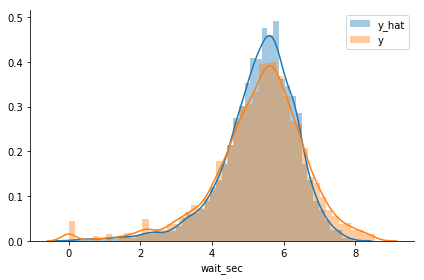

In [38]:
#wait time comparison
sns.distplot(y_pred, label='y_hat')
sns.distplot(y_test, label='y')
plt.legend()
sns.despine()
plt.tight_layout();

__Observation:__
<font color=blue> Overall, wait time prediction is slightly higher than the actual wait time (around mean wait time range) </font>

In [39]:
wait_sec_train = np.expm1(y_train).round()
np.quantile(wait_sec_train, [0, 0.05, 0.5, 0.95, 0.99])

array([   0.  ,   18.  ,  233.  , 1296.9 , 3171.72])

In [40]:
wait_sec_true = np.expm1(y_test).round()
wait_sec_predicted = np.expm1(y_pred).round()
# clip very high values
wait_sec_predicted = np.clip(wait_sec_predicted, 0, np.quantile(wait_sec_train, 0.95))

residual = wait_sec_predicted - wait_sec_true

In [41]:
print("Mean absolute error:", np.abs(residual).mean())
print("Median absolute error:", np.abs(residual).median())
print("Mean absolute percentage error:",((np.abs(residual).sum()/ wait_sec_predicted.sum()) * 100) /residual.count())

Mean absolute error: 172.90452169617342
Median absolute error: 56.0
Mean absolute percentage error: 0.009479136532792127


__Observation:__
<font color=blue> <br>
    Overall, Xgboost regressor model has outperformed base linear model and is giving closer predictions of wait time.<br>
    This can be further improved by: </font> <br>
    -  revisiting feature engineering steps and adding other relevant features for this estimation
    -  fine tuning boosting model further 

In [81]:
import pickle

In [43]:
# save model to file
pickle.dump(grid, open("Quito_waittime_xgboost_model.pickle.dat", "wb"))

In [82]:
# load model from file
loaded_model = pickle.load(open("Quito_waittime_xgboost_model.pickle.dat", 'rb'))

In [83]:
loaded_model

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_child_weight': [5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [84]:
type(loaded_model)

sklearn.model_selection._search.GridSearchCV

In [85]:
loaded_model.score(X_test, y_test)

0.6433252916588935

In [86]:
# Predict on testing and training set
y_pred = loaded_model.best_estimator_.predict(X_test)
y_train_pred = loaded_model.best_estimator_.predict(X_train)

In [87]:
# Report testing and training RMSE
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))


# Print the r2 score
print('Test R2 Score: ', r2_score(y_test, y_pred))
print('Train R2 Score: ', r2_score(y_train, y_train_pred))

# Test LM RMSE 0.9052403370152049; Train LM R2 Score: 0.509860642735872
# better than linear model regression 

Test RMSE: 0.7746933804592973
Train RMSE: 0.672392976834709
Test R2 Score:  0.6433252916588935
Train R2 Score:  0.7417897286852848


In [88]:
loaded_model.best_estimator_.feature_importances_

array([0.07301588, 0.08465608, 0.07539683, 0.06640211, 0.16455026,
       0.12301587, 0.02222222, 0.0037037 , 0.02751323, 0.02671958,
       0.0010582 , 0.0021164 , 0.11428571, 0.08571429, 0.05899471,
       0.07063492], dtype=float32)

In [89]:
X_test.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration_log', 'dist_meters_log',
       'pDayofWeek', 'pYear', 'pMonth', 'pHour', 'holiday', 'weekend',
       'avg_speed', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing'],
      dtype='object')

In [98]:
from xgboost import plot_importance
#plot_importance(loaded_model.best_estimator_)

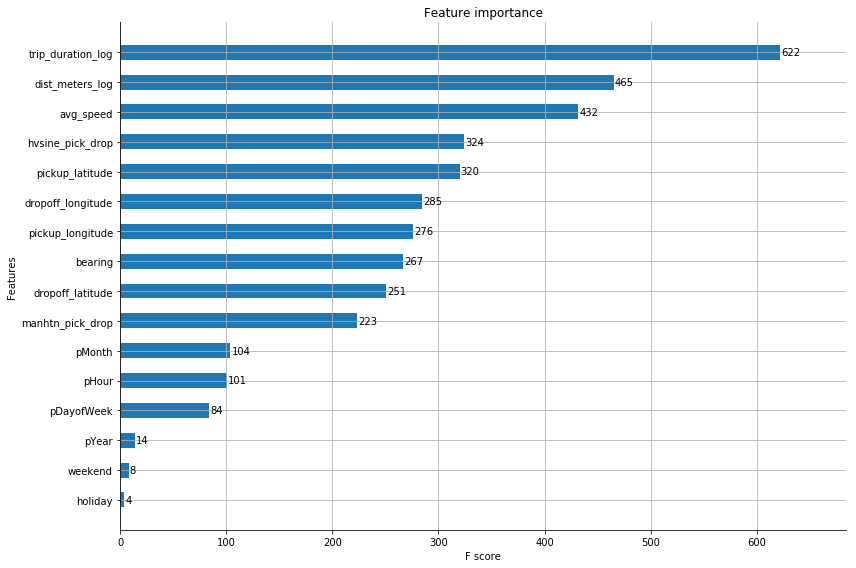

In [99]:
# feature importance
fig =  plt.figure(figsize = (12,8))
axes = fig.add_subplot(111)
plot_importance(loaded_model.best_estimator_,ax = axes,height =0.5)
sns.despine()
plt.tight_layout()